In [24]:
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'2.4.0-rc0'

In [3]:
def plot_series(time, series, format='-', start=0, end=None, label=None, title=None):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

## Trend and Seasonality

In [4]:
def trend(time, slope=0):
    return time*slope

Let's create a time series that trends upward

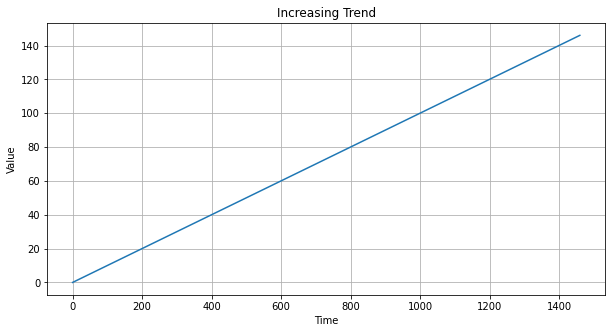

In [5]:
time = np.arange(4*365 + 1)
baseline = 10
series = trend(time, 0.1)
plot_series(time, series, title='Increasing Trend')

Now let's generate a time series with seasonal pattern

In [6]:
def seasonal_pattern(season_time):
    """Generate a arbitrary pattern"""
    return np.where(season_time<0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))
def seasonality(time, period=365, amplitude=40, phase=0):
    """Pattern repeats after an interval"""
    season_time = ((time + phase) % period) /period
    return amplitude * seasonal_pattern(season_time)

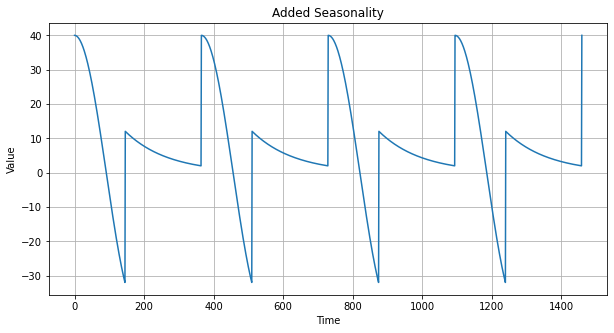

In [7]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series, title='Added Seasonality')

Now let's create a time series with both seasonality and trend

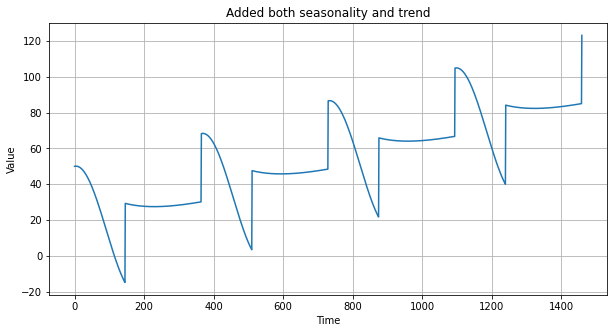

In [8]:
slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series, title='Added both seasonality and trend')

# Noise

Now let's add some white noise as very little real time problems have a smooth cure

In [9]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

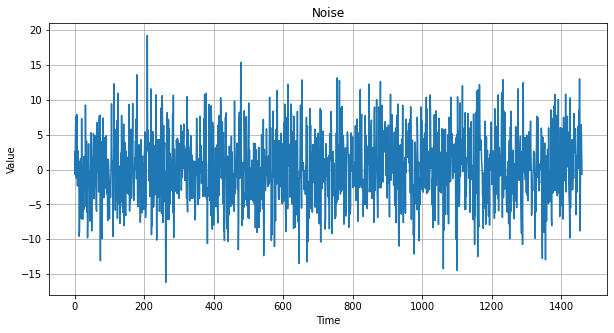

In [10]:
noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)
plot_series(time, noise, title='Noise')

Adding Noise to our series

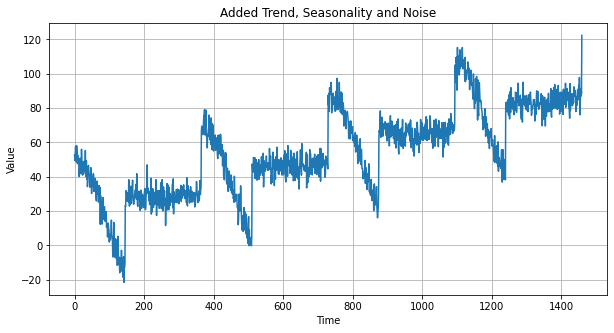

In [11]:
series += noise
plot_series(time, series, title='Added Trend, Seasonality and Noise')

Now let's split it into two parts, training and validation

In [12]:
split_time = 1000
y_train = series[:split_time]
X_train = time[:split_time]
y_valid = series[split_time:]
X_valid = time[split_time:]

## Defining two different autocorrelation functions

In [13]:
def autocorrelation_1(time, amplitude=40, seed=None):
    rnd = np.random.RandomState(seed)
    phi_1 = 0.5
    phi_2 = -0.1
    ar = rnd.randn(len(time)+50)
    ar[:50] = 100
    for i in range(50, len(time)+50):
        ar[i] += phi_1*ar[i-50]
        ar[i] += phi_2*ar[i-33]
    return amplitude*ar[50:]
def autocorrelation_2(time, amplitude=40, seed=None):
    rnd = np.random.RandomState(seed)
    phi = 0.8
    ar = rnd.randn(len(time)+1)
    for step in range(1, len(time)+1):
        ar[step] += phi*ar[step-1]
    return amplitude*ar[1:]

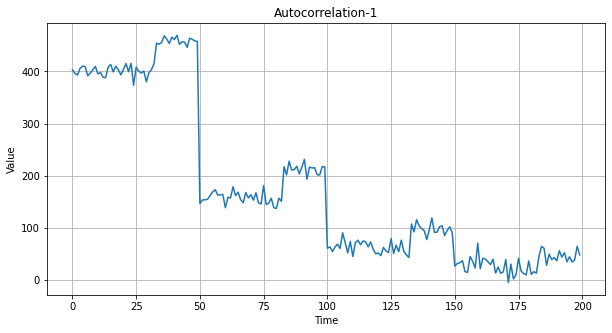

In [14]:
series = autocorrelation_1(time, amplitude=10, seed=42)
plot_series(time[:200], series[:200], title='Autocorrelation-1')

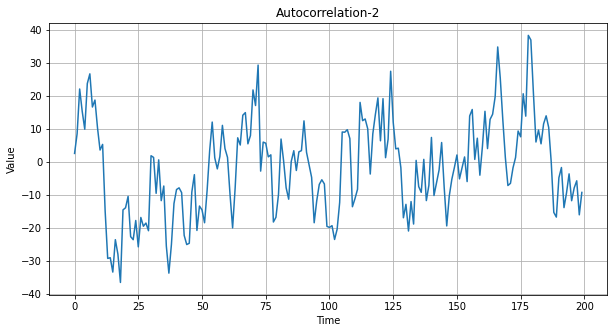

In [15]:
series = autocorrelation_2(time, amplitude=10, seed=42)
plot_series(time[:200], series[:200], title='Autocorrelation-2')

## Adding trend and seasonality

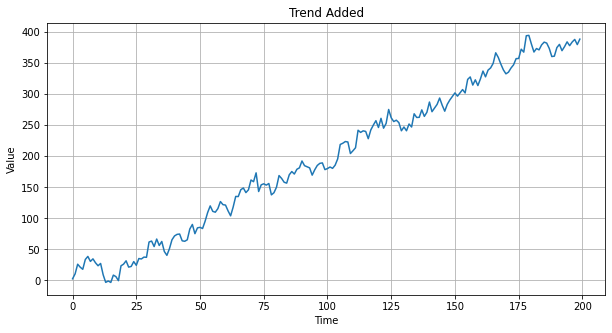

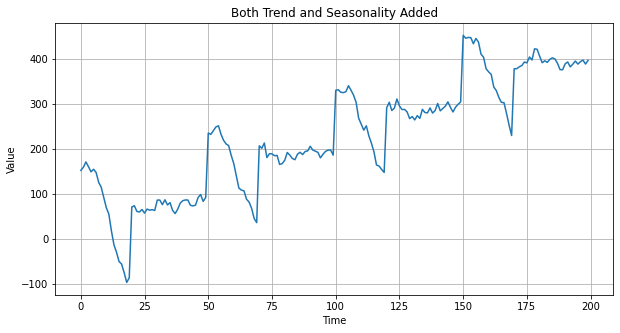

In [16]:
series = autocorrelation_2(time, 10, 42) + trend(time, 2)
plot_series(time[:200], series[:200], title='Trend Added')
series = autocorrelation_2(time, 10, 42) + trend(time, 2) + seasonality(time, period=50, amplitude=150)
plot_series(time[:200], series[:200], title='Both Trend and Seasonality Added')

## Now let us add some impactful event, e.g failure of business

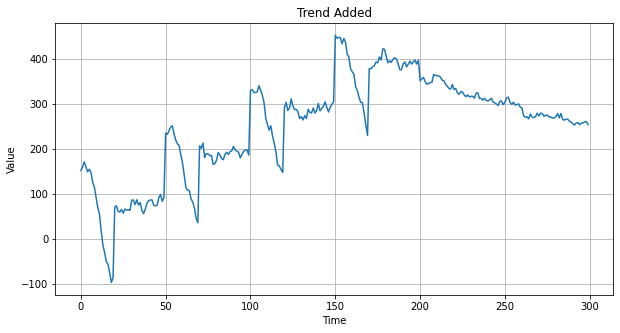

In [17]:
series = autocorrelation_2(time, 10, 42) + trend(time, 2) + seasonality(time, period=50, amplitude=150)
series2 = autocorrelation_2(time, 5, 42) + trend(time, -1) + seasonality(time, period=50, amplitude=2) + 550
series[200:] = series2[200:]
# series += white_noise(time, 30)
plot_series(time[:300], series[:300], title='Trend Added')


## Impulse

In [18]:
def impulse(time, num_of_impulses=10, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=num_of_impulses)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand()*amplitude
    return series

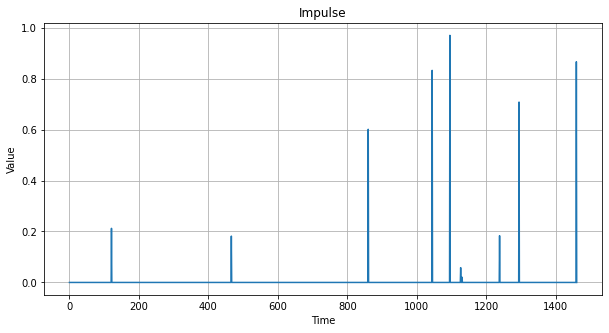

In [19]:
signal = impulse(time, seed=42)
plot_series(time, signal, title='Impulse')

## Adding deterioration to signal

In [20]:
def autocorrelation(source, option):
    ar = source.copy()
    for step, value in enumerate(source):
        for lag, phi in option.items():
            if(step - lag) > 0:
                ar[step] += phi*ar[step-lag]
    return ar

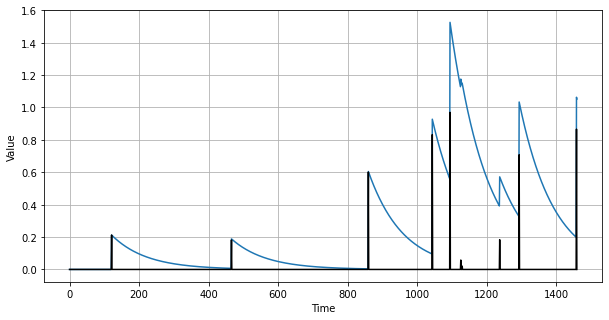

In [21]:
signal = impulse(time, num_of_impulses=10, amplitude=1, seed=42)
series = autocorrelation(signal, {1:0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

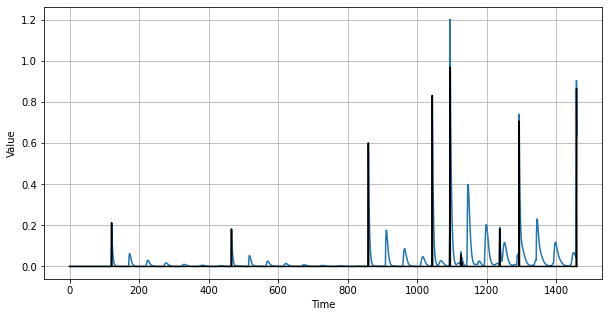

In [22]:
signal = impulse(time, num_of_impulses=10, amplitude=1, seed=42)
series = autocorrelation(signal, {1 : 0.7, 50 : 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

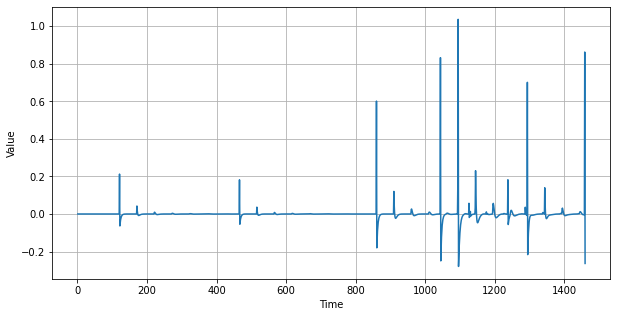

In [23]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)